In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch 
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [2]:
dataset = MNIST(root = 'data/', train = True , transform = ToTensor() , download=True,)
test_ds = MNIST(root = 'data/', train = True , transform = ToTensor())

image.shape: torch.Size([1, 28, 28])
Label: 2


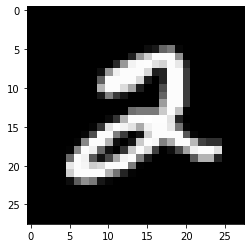

In [3]:
image, label = dataset[5]
print('image.shape:', image.shape)
plt.imshow(image[0], cmap='gray')
print('Label:', label)

In [4]:
train_ds , val_ds = random_split(dataset , [50000,10000])

In [5]:
train_loader = DataLoader(train_ds, batch_size = 128, shuffle = True , num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = 128*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


images.shape: torch.Size([128, 1, 28, 28])


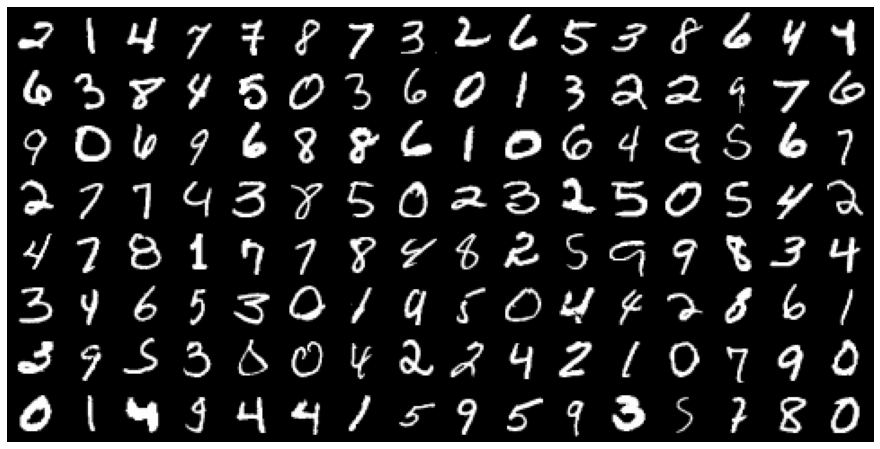

In [6]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [7]:
class MnistModel(nn.Module):

  def __init__(self,num_inputs,hidden_layer,num_outputs):
    super().__init__()
    self.linear1 = nn.Linear(num_inputs,hidden_layer)
    self.linear2 = nn.Linear(hidden_layer,num_outputs)
  
  def forward(self,xb):
    xb = xb.view(xb.size(0),-1)
    out = self.linear1(xb)
    out = F.relu(out)
    out = self.linear2(out)
    return out
  
  def training_step(self,batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss
  
  def validation_step(self,batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss': loss , 'val_acc': acc}
  
  def validation_epoch_end(self,outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accuracy = [x['val_acc'] for x in outputs]
    epoch_accuracy = torch.stack(batch_accuracy).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_accuracy.item()}
  
  def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


In [8]:
def accuracy(outputs,labels):
  _,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds==labels).item() / len(preds))

##Connecting to GPU

In [9]:
torch.cuda.is_available() ##checking if GPU is available.

True

In [10]:
## Connecting to the device available.
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
##Function that moves he data and model to the available device.
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [13]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [15]:
def evaluate(model,val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [21]:
def fit(epochs,lr,model,train_loader,val_loader,opt_func = torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(),lr)
  for epoch in range(epochs):
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    result = evaluate(model,val_loader)
    model.epoch_end(epoch,result)
    history.append(result)
  return history

In [22]:
input_size = 784
hidden_layer = 32
output_size = 10

In [23]:
model = MnistModel(input_size,hidden_layer,output_size)
to_device(model,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [24]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3052432537078857, 'val_acc': 0.09775390475988388}]

In [25]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2969, val_acc: 0.9163
Epoch [1], val_loss: 0.2157, val_acc: 0.9350
Epoch [2], val_loss: 0.1562, val_acc: 0.9543
Epoch [3], val_loss: 0.1644, val_acc: 0.9519
Epoch [4], val_loss: 0.1697, val_acc: 0.9519


In [26]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1151, val_acc: 0.9685
Epoch [1], val_loss: 0.1121, val_acc: 0.9696
Epoch [2], val_loss: 0.1101, val_acc: 0.9702
Epoch [3], val_loss: 0.1098, val_acc: 0.9703
Epoch [4], val_loss: 0.1075, val_acc: 0.9712


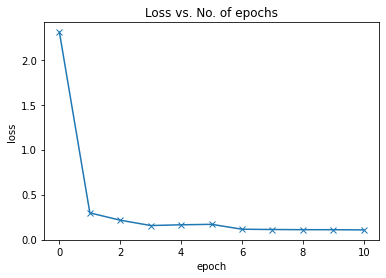

In [27]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

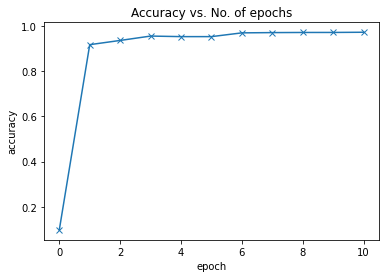

In [28]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [29]:
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [30]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

In [31]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.09711561352014542, 'val_acc': 0.9722656011581421}